In [9]:
#importing necessary libraries
from api.mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod


In [10]:
SulzerRegionalCensusOverlap = pd.read_csv('../../can-summer-2023/data/extra_data/sulzerCensusOverlap20Walking1.csv')
SulzerRegionalCensusOverlap.head(1)

,Unnamed: 0,Census Tract,geometry,Area Within Radius,census Area,Percent Overlap
0,0,17031843700,"POLYGON ((-87.688695 41.950258, -87.692695 41....",0.091182,1.266938,0.071971


In [11]:
census_demos = pd.read_csv('../../can-summer-2023/data/final_data/census_demos.csv')
census_demos.head(1)

,geoid,Unnamed: 0,qualifying name,geometry,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,...,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races
0,17031823303,0,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.720963 41.683952, -87.720304 41....",4059,0.047056,0.099039,0.075634,0.05223,0.040404,...,0.912801,0.087199,0.806432,0.795763,0.078098,0.009855,0.0,0.0,0.072924,0.04336


# Merging Census Data for Sulzer Regional

In [12]:
#Renaming a column to 'geoid' so that it will match the internet_demos file
sulzerregional = SulzerRegionalCensusOverlap.rename(columns={'Census Tract': 'geoid'}, inplace=True)
#Dropping unnecessary columns
sulzerregional = SulzerRegionalCensusOverlap.drop(columns=['Unnamed: 0', 'Area Within Radius', 'census Area'], axis=1)
sulzerregional.head(2)

,geoid,geometry,Percent Overlap
0,17031843700,"POLYGON ((-87.688695 41.950258, -87.692695 41....",0.071971
1,17031050500,"POLYGON ((-87.678695 41.948543, -87.680695 41....",0.694974


In [13]:
sulzerregional_merge =  census_demos.merge(sulzerregional, on = 'geoid')
sulzerregional_merge.head(2)

,geoid,Unnamed: 0,qualifying name,geometry_x,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,...,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,geometry_y,Percent Overlap
0,17031843700,603,"Census Tract 8437, Cook County, Illinois","POLYGON ((-87.696809 41.950068, -87.696809 41....",2482,0.118453,0.042707,0.058421,0.056809,0.00967,...,0.858654,0.694198,0.035052,0.0,0.082192,0.0,0.020548,0.168010,"POLYGON ((-87.688695 41.950258, -87.692695 41....",0.071971
1,17031050500,608,"Census Tract 505, Cook County, Illinois","POLYGON ((-87.688223 41.954034, -87.687493 41....",5587,0.124217,0.051727,0.078754,0.054054,0.02112,...,0.917722,0.836585,0.000358,0.0,0.078217,0.0,0.028817,0.056023,"POLYGON ((-87.678695 41.948543, -87.680695 41....",0.694974


- The 'geometry' column in census_demos represents the total area for each census tract.
- The 'geometry' column in Sulzer represents the portion of area for each census tract that only the Sulzer branch overlaps on.
- Thus, these two 'geometry' columns will not be the same values. So, since we are only looking for overlap, we can remove the 'geometry' column from the census_demos dataframe. When merging, Python changes the census_demos 'geometry' to 'geometry_x' and Sulzer Regional's 'geometry' to 'geometry_y'.

In [6]:
#Dropping geometry_x and renaming geometry_y as just geometry
sulzerregional_merge_changes = sulzerregional_merge.drop(columns=['geometry_x'], axis=1).rename(columns={'geometry_y':'geometry'})
sulzerregional_merge_changes.head(2)

,geoid,Unnamed: 0,qualifying name,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,...,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,geometry,Percent Overlap
0,17031843700,603,"Census Tract 8437, Cook County, Illinois",2482,0.118453,0.042707,0.058421,0.056809,0.00967,0.059629,...,0.858654,0.694198,0.035052,0.0,0.082192,0.0,0.020548,0.168010,"POLYGON ((-87.688695 41.950258, -87.692695 41....",0.071971
1,17031050500,608,"Census Tract 505, Cook County, Illinois",5587,0.124217,0.051727,0.078754,0.054054,0.02112,0.079291,...,0.917722,0.836585,0.000358,0.0,0.078217,0.0,0.028817,0.056023,"POLYGON ((-87.678695 41.948543, -87.680695 41....",0.694974


## Age Census Data for Canaryville 

Options to Input as DemographicsVariables
- Percent: under 5 years
- Percent: 5 to 9 years	
- Percent: 10 to 14 years	
- Percent: 15 to 19 years	
- Percent: 20 to 24 years	
- Percent: 25 to 29 years	
- Percent: 30 to 34 years	
-  Percent: 35 to 39 years	
 - Percent: 50 to 54 years	
- Percent: 55 to 59 years	
 - Percent: 60 to 64 years	
- Percent: 65 to 69 years	
- Percent: 70 to 74 years	
- Percent: 75 to 79 years	
- Percent: 80 to 84 years	
- Percent: 85 years and over

We want to only look at the age census information for the Canaryville branch. We need to extract only the age census information from the census_demos dataset that includes ALL of the census information.

In [7]:
def Age_by_branch(DemographicsVariables):
    """ This function takes the population of each variables and devide it by the population to give us the perecntage of how many people have a specific age in the overlapping area of the branch"""
    print(DemographicsVariables)
    pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['total population']).sum()
    Branch_pop_Var = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['total population']).sum()
    result = Branch_pop_Var/pop_in_branch
    return result

In [8]:
Age_by_branch('Percent: 20 to 24 years')

Percent: 20 to 24 years


0.04794190137930745

In [9]:
Age_by_branch('Percent: 75 to 79 years')

Percent: 75 to 79 years


0.016890790285065807

## Race Census Data for Canaryville 

Options to Input as DemographicsVariables
- Percent: White Alone	
- Percent: Black or African American Alone	
- Percent: American Indian and Alaska Native Alone	
- Percent: Asian Alone	
- Percent: Native Hawaiian and Other Pacific Islander Alone	Percent: Some Other Race Alone	
- Percent: Two or More Races

We want to only look at the Race census information for the Canaryville branch. We need to extract only the Race census information from the census_demos dataset that includes ALL of the census information.

In [10]:
def Race_by_branch(DemographicsVariables):
    """ This function takes the population of each variables and devide it by the population to give us the perecntage of how many people have a specific Race in the overlapping area of the branch"""
    print(DemographicsVariables)
    pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['total population']).sum()
    Branch_pop_Var = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['total population']).sum()
    result = Branch_pop_Var/pop_in_branch
    return result

In [11]:
Race_by_branch('Percent: American Indian and Alaska Native Alone')

Percent: American Indian and Alaska Native Alone


0.001798558597242687

In [12]:
Race_by_branch('Percent: Two or More Races')

Percent: Two or More Races


0.07732194750179133

## Education Census Data for Canaryville 

Options to Input as DemographicsVariables
- Percent: 25+ Less Than High School	
- Percent: 25+ High School or More	
- Percent: 25+ Some College or More	
- Percent: 25+ Bachelor's Degree or More	
- Percent: 25+ Master's Degree or More	
- Percent: 25+ Professional School Degree or More	
- Percent: 25+ Doctorate Degree

In [14]:
def Education_by_branch(DemographicsVariables):
    """ This function takes the population of each variables and devide it by the population to give us the perecntage of how many people have a specific degree in the overlapping area of the branch"""
    print(DemographicsVariables)
    pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['population 25 years and over']).sum()
    Branch_pop_Var = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['population 25 years and over']).sum()
    result = Branch_pop_Var/pop_in_branch
    return result

In [15]:
Education_by_branch('Percent: 25+ High School or More')

Percent: 25+ High School or More


0.9570198153572983

In [16]:
Education_by_branch('Percent: 25+ Master\'s Degree or More')

Percent: 25+ Master's Degree or More


0.3059205283271616

In [17]:
Education_by_branch('Percent: 25+ Doctorate Degree')

Percent: 25+ Doctorate Degree


0.02856970695351582

## Commute Census Data for Canaryville

We want to only look at the commute census information for the Canary branch. We need to extract only the commute census information from the census_demos dataset that includes ALL of the census information.

Possible Variables that can be used for 'DemographicsVariables':

- Percent Owner and Renter Occupied Housing: No Vehicles
- Percent Owner and Renter Occupied Housing: 1 Vehicle
- Percent Owner and Renter Occupied Housing: 2 Vehicles
- Percent Owner and Renter Occupied Housing: 3 Vehicles
- Percent Owner and Renter Occupied Housing: 4 Vehicles
- Percent Owner and Renter Occupied Housing: 5 or More Vehicles
- Percent Renter-Occupied Housing: No Vehicles
- Percent Renter-Occupied Housing: 1 Vehicle
- Percent Renter-Occupied Housing: 2 Vehicles
- Percent Renter-Occupied Housing: 3 Vehicles
- Percent Renter-Occupied Housing: 4 Vehicles
- Percent Renter-Occupied Housing: 5 or More Vehicles
- Percent Workers 16+: Car, Truck, or Van
- Percent Workers 16+: Drove Alone
- Percent Workers 16+: Carpooled
- Percent Workers 16+: Public Transportation (Includes Taxi)
- Percent Workers 16+: Motorcycle
- Percent Workers 16+: Bicycle
- Percent Workers 16+: Walked
- Percent Workers 16+: Other Means

*To get a percentage, you write: commute_by_branch('your pick from above')

In [68]:
def commute_by_branch(DemographicsVariables):
    if DemographicsVariables == 'Percent Owner and Renter Occupied Housing: No Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 1 Vehicle' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 2 Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 3 Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 4 Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 5 or More Vehicles':
        print(DemographicsVariables)
        pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['occupied housing units']).sum()
        Branch_pop_withCommute = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['occupied housing units']).sum() 
        result = Branch_pop_withCommute/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Renter-Occupied Housing: No Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 1 Vehicle' or DemographicsVariables == 'Percent Renter-Occupied Housing: 2 Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 3 Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 4 Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 5 or More Vehicles':
        print(DemographicsVariables)
        pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['renter-occupied housing units']).sum()
        Branch_pop_withCommute = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['renter-occupied housing units']).sum() 
        result = Branch_pop_withCommute/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Workers 16+: Car, Truck, or Van ' or DemographicsVariables == 'Percent Workers 16+: Drove Alone' or DemographicsVariables == 'Percent Workers 16+: Carpooled' or DemographicsVariables == 'Percent Workers 16+: Public Transportation (Includes Taxi)' or DemographicsVariables == 'Percent Workers 16+: Motorcycle' or DemographicsVariables == 'Percent Workers 16+: Bicycle' or DemographicsVariables == 'Percent Workers 16+: Walked' or DemographicsVariables == 'Percent Workers 16+: Other Means':
        print(DemographicsVariables)
        pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['workers 16 years and over']).sum()
        Branch_pop_withCommute = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['workers 16 years and over']).sum() 
        result = Branch_pop_withCommute/pop_in_branch
        return result

### Examples of inputs -- checking work

In [69]:
commute_by_branch('Percent Owner and Renter Occupied Housing: No Vehicles')

Percent Owner and Renter Occupied Housing: No Vehicles


0.21918545529957068

In [70]:
commute_by_branch('Percent Owner and Renter Occupied Housing: 1 Vehicle')

Percent Owner and Renter Occupied Housing: 1 Vehicle


0.5008423630482802

In [71]:
commute_by_branch('Percent Owner and Renter Occupied Housing: 2 Vehicles')

Percent Owner and Renter Occupied Housing: 2 Vehicles


0.24460249576772053

In [72]:
commute_by_branch('Percent Owner and Renter Occupied Housing: 3 Vehicles')

Percent Owner and Renter Occupied Housing: 3 Vehicles


0.028056216614302756

In [73]:
commute_by_branch('Percent Workers 16+: Public Transportation (Includes Taxi)')

Percent Workers 16+: Public Transportation (Includes Taxi)


0.30156958362124436

In [74]:
commute_by_branch('Percent Workers 16+: Bicycle')

Percent Workers 16+: Bicycle


0.021661549651579296

In [75]:
commute_by_branch('Percent Workers 16+: Car, Truck, or Van ')

Percent Workers 16+: Car, Truck, or Van 


0.4061756433127706

## Income Census Data for Canaryville 


We want to only look at the income census information for the canaryville branch. We need to extract only the income census information from the census_demos dataset that includes ALL of the census information.

Possible Variables that can be used for 'DemographicsVariables':

- Percent Population in Labor Force 16+: Employed

- Percent Population in Labor Force 16+: Unemployed

- Percent Households: Less Than $10,000

- Percent Households: $10,000 to $14,999

- Percent Households: $15,000 to $19,999

- Percent Households: $20,000 to $24,999

- Percent Households: $25,000 to $29,999

- Percent Households: $30,000 to $34,999

- Percent Households: $35,000 to $39,999

- Percent Households: $40,000 to $44,999

- Percent Households: $45,000 to $49,999

- Percent Households: $50,000 to $59,999

- Percent Households: $60,000 to $74,999

- Percent Households: $75,000 to $99,999

- Percent Households: $100,000 to $124,999

- Percent Households: $125,000 to $149,999

- Percent Households: $150,000 to $199,999

- Percent Households: $200,000 or more

- Percent Ages 18-64: Living in Poverty

- Percent Ages 18-64: At or Above Poverty Level

- Percent Households: With Public Assistance Income

- Percent Households: No Public Assistance Income


*To get a percentage, you write: income_by_branch('your pick from above')



In [76]:
def income_by_branch(DemographicsVariables):
    if DemographicsVariables == 'Percent Population in Labor Force 16+: Employed' or DemographicsVariables == 'Percent Population in Labor Force 16+: Unemployed':
        print(DemographicsVariables)
        pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['civilian population in labor force 16 years and over']).sum()
        Branch_pop_withIncome = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['civilian population in labor force 16 years and over']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Households: Less Than $10,000' or DemographicsVariables == 'Percent Households: $10,000 to $14,999' or DemographicsVariables == 'Percent Households: $15,000 to $19,999' or DemographicsVariables == 'Percent Households: $20,000 to $24,999' or DemographicsVariables == 'Percent Households: $25,000 to $29,999' or DemographicsVariables == 'Percent Households: $30,000 to $34,999' or DemographicsVariables == 'Percent Households: $35,000 to $39,999' or DemographicsVariables == 'Percent Households: $40,000 to $44,999' or DemographicsVariables == 'Percent Households: $45,000 to $49,999' or DemographicsVariables == 'Percent Households: $50,000 to $59,999' or DemographicsVariables == 'Percent Households: $60,000 to $74,999' or DemographicsVariables == 'Percent Households: $75,000 to $99,999' or DemographicsVariables == 'Percent Households: $100,000 to $124,999' or DemographicsVariables == 'Percent Households: $125,000 to $149,999' or DemographicsVariables == 'Percent Households: $150,000 to $199,999' or DemographicsVariables == 'Percent Households: $200,000 or more':
        print(DemographicsVariables)
        pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['total households reporting income']).sum()
        Branch_pop_withIncome = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['total households reporting income']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Ages 18-64: Living in Poverty' or DemographicsVariables == 'Percent Ages 18-64: At or Above Poverty Level':
        print(DemographicsVariables)
        pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['population age 18 to 64 for whom poverty status  is determined']).sum()
        Branch_pop_withIncome = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['population age 18 to 64 for whom poverty status  is determined']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Households: With Public Assistance Income' or DemographicsVariables == 'Percent Households: No Public Assistance Income':
        print(DemographicsVariables)
        pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['total households reporting public assistance income status']).sum()
        Branch_pop_withIncome = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['total households reporting public assistance income status']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result

### Examples of inputs -- checking work

In [77]:
income_by_branch('Percent Population in Labor Force 16+: Unemployed')

Percent Population in Labor Force 16+: Unemployed


0.04296006431259511

In [78]:
income_by_branch('Percent Population in Labor Force 16+: Employed')

Percent Population in Labor Force 16+: Employed


0.9570399356874049

In [79]:
income_by_branch('Percent Households: Less Than $10,000')

Percent Households: Less Than $10,000


0.032479264944266215

In [80]:
income_by_branch('Percent Households: $10,000 to $14,999')

Percent Households: $10,000 to $14,999


0.015118244474175788

In [81]:
income_by_branch('Percent Households: $150,000 to $199,999')

Percent Households: $150,000 to $199,999


0.10013534180173865

In [82]:
income_by_branch('Percent Ages 18-64: Living in Poverty')

Percent Ages 18-64: Living in Poverty


0.057696236819530164

In [83]:
income_by_branch('Percent Ages 18-64: At or Above Poverty Level')

Percent Ages 18-64: At or Above Poverty Level


0.9423037631804698

In [84]:
income_by_branch('Percent Households: With Public Assistance Income')

Percent Households: With Public Assistance Income


0.021367072132497538

In [85]:
income_by_branch('Percent Households: No Public Assistance Income')

Percent Households: No Public Assistance Income


0.9786329278675023

## Internet Census Data for Canaryville

We want to only look at the internet census information for the canary branch. We need to extract only the internet census information from the census_demos dataset that includes ALL of the census information.

Possible Variables that can be used for 'DemographicsVariables':

- Percent of People with Internet Access
- Percent of People without Internet Access
- Percent of People with Computers
- Percent of People without Computers
- Percent of People with Computers and Internet

*To get a percentage, you write: internet_by_branch('your pick from above')

In [86]:
def internet_by_branch(DemographicsVariables):
    ''' We are creating a function that allows me to retrieve only the internet census data, and then compare this with Altgeld'''
    pop_in_branch = (sulzerregional_merge_changes['Percent Overlap']  * sulzerregional_merge_changes['Total']).sum()
    Branch_pop_withInternet = (sulzerregional_merge_changes['Percent Overlap'] * sulzerregional_merge_changes[DemographicsVariables] * sulzerregional_merge_changes['Total']).sum() 
    result = Branch_pop_withInternet/pop_in_branch
    return result  

### Examples of Inputs--checking work

In [87]:
internet_by_branch('Percent of People with Internet Access')

0.9459405354013408

In [88]:
internet_by_branch('Percent of People with Computers')

0.9043969939648436

## Creating Branch Snapshot

In [89]:
branch_snapshot_df = pd.DataFrame({'Branch': ['Sulzer Regional']})
branch_snapshot_df

,Branch
0,Sulzer Regional


In [90]:
def branch_demographics(branch_snapshot_df):
    list1 = ['Percent of People with Internet Access',
             'Percent of People without Internet Access',
             'Percent of People with Computers', 
             'Percent of People without Computers', 
             'Percent of People with Computers and Internet']
    for i in list1:
        branch_snapshot_df[i] = internet_by_branch(i)
    
    list2 = ['Percent Population in Labor Force 16+: Employed',
             'Percent Population in Labor Force 16+: Unemployed',
             'Percent Households: Less Than $10,000',
             'Percent Households: $10,000 to $14,999',
             'Percent Households: $15,000 to $19,999',
             'Percent Households: $20,000 to $24,999',
             'Percent Households: $25,000 to $29,999',
             'Percent Households: $30,000 to $34,999',
             'Percent Households: $35,000 to $39,999',
             'Percent Households: $40,000 to $44,999',
             'Percent Households: $45,000 to $49,999',
             'Percent Households: $50,000 to $59,999',
             'Percent Households: $60,000 to $74,999',
             'Percent Households: $75,000 to $99,999',
             'Percent Households: $100,000 to $124,999',
             'Percent Households: $125,000 to $149,999',
             'Percent Households: $150,000 to $199,999',
             'Percent Households: $200,000 or more',
             'Percent Ages 18-64: Living in Poverty',
             'Percent Ages 18-64: At or Above Poverty Level',
             'Percent Households: With Public Assistance Income',
             'Percent Households: No Public Assistance Income']
    for i in list2:
        branch_snapshot_df[i] = income_by_branch(i)
    
    list3 = ['Percent Owner and Renter Occupied Housing: No Vehicles',
             'Percent Owner and Renter Occupied Housing: 1 Vehicle',
             'Percent Owner and Renter Occupied Housing: 2 Vehicles',
             'Percent Owner and Renter Occupied Housing: 3 Vehicles',
             'Percent Owner and Renter Occupied Housing: 4 Vehicles',
             'Percent Owner and Renter Occupied Housing: 5 or More Vehicles',
             'Percent Renter-Occupied Housing: No Vehicles',
             'Percent Renter-Occupied Housing: 1 Vehicle',
             'Percent Renter-Occupied Housing: 2 Vehicles',
             'Percent Renter-Occupied Housing: 3 Vehicles',
             'Percent Renter-Occupied Housing: 4 Vehicles',
             'Percent Renter-Occupied Housing: 5 or More Vehicles',
             'Percent Workers 16+: Car, Truck, or Van ',
             'Percent Workers 16+: Drove Alone',
             'Percent Workers 16+: Carpooled',
             'Percent Workers 16+: Public Transportation (Includes Taxi)',
             'Percent Workers 16+: Motorcycle',
             'Percent Workers 16+: Bicycle',
             'Percent Workers 16+: Walked',
             'Percent Workers 16+: Other Means']
    for i in list3:
        branch_snapshot_df[i] = commute_by_branch(i)
    
    list4 = ['Percent: White Alone',
             'Percent: Black or African American Alone',
             'Percent: American Indian and Alaska Native Alone',
             'Percent: Asian Alone',
             'Percent: Native Hawaiian and Other Pacific Islander Alone',
             'Percent: Some Other Race Alone',
             'Percent: Two or More Races']
    for i in list4:
        branch_snapshot_df[i] = Race_by_branch(i)
        
    list5 = ['Percent: under 5 years',
             'Percent: 5 to 9 years',
             'Percent: 10 to 14 years',
             'Percent: 15 to 19 years',
             'Percent: 20 to 24 years',
             'Percent: 25 to 29 years',
             'Percent: 30 to 34 years',
             'Percent: 35 to 39 years',
             'Percent: 50 to 54 years',
             'Percent: 55 to 59 years',
             'Percent: 60 to 64 years',
             'Percent: 65 to 69 years',
             'Percent: 70 to 74 years',
             'Percent: 75 to 79 years',
             'Percent: 80 to 84 years',
             'Percent: 85 years and over']
    for i in list5:
        branch_snapshot_df[i] = Age_by_branch(i)
    
    list6 = ['Percent: 25+ Less Than High School', 
             'Percent: 25+ High School or More', 
             'Percent: 25+ Some College or More', 
             'Percent: 25+ Bachelor\'s Degree or More', 
             'Percent: 25+ Master\'s Degree or More',
             'Percent: 25+ Professional School Degree or More',
             'Percent: 25+ Doctorate Degree']
    for i in list6: 
        branch_snapshot_df[i] = Education_by_branch(i)
       
    return branch_snapshot_df

In [91]:
branch_demographics(branch_snapshot_df)

Percent Population in Labor Force 16+: Employed
Percent Population in Labor Force 16+: Unemployed
Percent Households: Less Than $10,000
Percent Households: $10,000 to $14,999
Percent Households: $15,000 to $19,999
Percent Households: $20,000 to $24,999
Percent Households: $25,000 to $29,999
Percent Households: $30,000 to $34,999
Percent Households: $35,000 to $39,999
Percent Households: $40,000 to $44,999
Percent Households: $45,000 to $49,999
Percent Households: $50,000 to $59,999
Percent Households: $60,000 to $74,999
Percent Households: $75,000 to $99,999
Percent Households: $100,000 to $124,999
Percent Households: $125,000 to $149,999
Percent Households: $150,000 to $199,999
Percent Households: $200,000 or more
Percent Ages 18-64: Living in Poverty
Percent Ages 18-64: At or Above Poverty Level
Percent Households: With Public Assistance Income
Percent Households: No Public Assistance Income
Percent Owner and Renter Occupied Housing: No Vehicles
Percent Owner and Renter Occupied Hous

,Branch,Percent of People with Internet Access,Percent of People without Internet Access,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent Population in Labor Force 16+: Employed,Percent Population in Labor Force 16+: Unemployed,"Percent Households: Less Than $10,000","Percent Households: $10,000 to $14,999",...,Percent: 75 to 79 years,Percent: 80 to 84 years,Percent: 85 years and over,Percent: 25+ Less Than High School,Percent: 25+ High School or More,Percent: 25+ Some College or More,Percent: 25+ Bachelor's Degree or More,Percent: 25+ Master's Degree or More,Percent: 25+ Professional School Degree or More,Percent: 25+ Doctorate Degree
0,Sulzer Regional,0.945941,0.054059,0.904397,0.031672,0.921576,0.95704,0.04296,0.032479,0.015118,...,0.016891,0.00771,0.013193,0.04298,0.95702,0.877838,0.735809,0.305921,0.088658,0.02857


In [92]:
census_demos_average = census_demos[['Percent of People with Internet Access',
             'Percent of People without Internet Access',
             'Percent of People with Computers',
             'Percent of People without Computers',
             'Percent of People with Computers and Internet',
            'Percent Population in Labor Force 16+: Employed',
             'Percent Population in Labor Force 16+: Unemployed',
             'Percent Households: Less Than $10,000',
             'Percent Households: $10,000 to $14,999',
             'Percent Households: $15,000 to $19,999',
             'Percent Households: $20,000 to $24,999',
             'Percent Households: $25,000 to $29,999',
             'Percent Households: $30,000 to $34,999',
             'Percent Households: $35,000 to $39,999',
             'Percent Households: $40,000 to $44,999',
             'Percent Households: $45,000 to $49,999',
             'Percent Households: $50,000 to $59,999',
             'Percent Households: $60,000 to $74,999',
             'Percent Households: $75,000 to $99,999',
             'Percent Households: $100,000 to $124,999',
             'Percent Households: $125,000 to $149,999',
             'Percent Households: $150,000 to $199,999',
             'Percent Households: $200,000 or more',
             'Percent Ages 18-64: Living in Poverty',
             'Percent Ages 18-64: At or Above Poverty Level',
             'Percent Households: With Public Assistance Income',
             'Percent Households: No Public Assistance Income',
            'Percent Owner and Renter Occupied Housing: No Vehicles',
             'Percent Owner and Renter Occupied Housing: 1 Vehicle',
             'Percent Owner and Renter Occupied Housing: 2 Vehicles',
             'Percent Owner and Renter Occupied Housing: 3 Vehicles',
             'Percent Owner and Renter Occupied Housing: 4 Vehicles',
             'Percent Owner and Renter Occupied Housing: 5 or More Vehicles',
             'Percent Renter-Occupied Housing: No Vehicles',
             'Percent Renter-Occupied Housing: 1 Vehicle',
             'Percent Renter-Occupied Housing: 2 Vehicles',
             'Percent Renter-Occupied Housing: 3 Vehicles',
             'Percent Renter-Occupied Housing: 4 Vehicles',
             'Percent Renter-Occupied Housing: 5 or More Vehicles',
             'Percent Workers 16+: Car, Truck, or Van ',
             'Percent Workers 16+: Drove Alone',
             'Percent Workers 16+: Carpooled',
             'Percent Workers 16+: Public Transportation (Includes Taxi)',
             'Percent Workers 16+: Motorcycle',
             'Percent Workers 16+: Bicycle',
             'Percent Workers 16+: Walked',
             'Percent Workers 16+: Other Means',
            'Percent: White Alone',
             'Percent: Black or African American Alone',
             'Percent: American Indian and Alaska Native Alone',
             'Percent: Asian Alone',
             'Percent: Native Hawaiian and Other Pacific Islander Alone',
             'Percent: Some Other Race Alone',
             'Percent: Two or More Races',
             'Percent: under 5 years',
             'Percent: 5 to 9 years',
             'Percent: 10 to 14 years',
             'Percent: 15 to 19 years',
             'Percent: 20 to 24 years',
             'Percent: 25 to 29 years',
             'Percent: 30 to 34 years',
             'Percent: 35 to 39 years',
             'Percent: 50 to 54 years',
             'Percent: 55 to 59 years',
             'Percent: 60 to 64 years',
             'Percent: 65 to 69 years',
             'Percent: 70 to 74 years',
             'Percent: 75 to 79 years',
             'Percent: 80 to 84 years',
             'Percent: 85 years and over',
            'Percent: 25+ Less Than High School',
             'Percent: 25+ High School or More',
             'Percent: 25+ Some College or More',
             'Percent: 25+ Bachelor\'s Degree or More',
             'Percent: 25+ Master\'s Degree or More',
             'Percent: 25+ Professional School Degree or More',
             'Percent: 25+ Doctorate Degree']].mean()



In [93]:
census_demos_avg_df = pd.DataFrame(census_demos_average).T
census_demos_avg_df.insert(0, 'Branch', 'Average Branches')
census_demos_avg_df

,Branch,Percent of People with Internet Access,Percent of People without Internet Access,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent Population in Labor Force 16+: Employed,Percent Population in Labor Force 16+: Unemployed,"Percent Households: Less Than $10,000","Percent Households: $10,000 to $14,999",...,Percent: 75 to 79 years,Percent: 80 to 84 years,Percent: 85 years and over,Percent: 25+ Less Than High School,Percent: 25+ High School or More,Percent: 25+ Some College or More,Percent: 25+ Bachelor's Degree or More,Percent: 25+ Master's Degree or More,Percent: 25+ Professional School Degree or More,Percent: 25+ Doctorate Degree
0,Average Branches,0.865607,0.134393,0.904691,0.095309,0.826165,0.900613,0.099387,0.089435,0.049482,...,0.023298,0.014911,0.01642,0.142024,0.857976,0.624766,0.384402,0.160552,0.048123,0.016976


In [94]:
branch_vs_average = pd.concat([branch_snapshot_df, census_demos_avg_df])
branch_vs_average

,Branch,Percent of People with Internet Access,Percent of People without Internet Access,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent Population in Labor Force 16+: Employed,Percent Population in Labor Force 16+: Unemployed,"Percent Households: Less Than $10,000","Percent Households: $10,000 to $14,999",...,Percent: 75 to 79 years,Percent: 80 to 84 years,Percent: 85 years and over,Percent: 25+ Less Than High School,Percent: 25+ High School or More,Percent: 25+ Some College or More,Percent: 25+ Bachelor's Degree or More,Percent: 25+ Master's Degree or More,Percent: 25+ Professional School Degree or More,Percent: 25+ Doctorate Degree
0,Sulzer Regional,0.945941,0.054059,0.904397,0.031672,0.921576,0.957040,0.042960,0.032479,0.015118,...,0.016891,0.007710,0.013193,0.042980,0.957020,0.877838,0.735809,0.305921,0.088658,0.028570
0,Average Branches,0.865607,0.134393,0.904691,0.095309,0.826165,0.900613,0.099387,0.089435,0.049482,...,0.023298,0.014911,0.016420,0.142024,0.857976,0.624766,0.384402,0.160552,0.048123,0.016976


In [95]:
branch_vs_average['Percent: 25+ Bachelor\'s Degree or More']

0    0.735809
0    0.384402
Name: Percent: 25+ Bachelor's Degree or More, dtype: float64

In [96]:
branch_vs_average['Percent Households: $200,000 or more']

0    0.207571
0    0.095580
Name: Percent Households: $200,000 or more, dtype: float64

In [97]:
difference_row_Sulzer = branch_vs_average.iloc[0:2,1:78].diff()
#difference_row

#difference_row = branch_vs_average.diff()
difference_row_Sulzer

,Percent of People with Internet Access,Percent of People without Internet Access,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent Population in Labor Force 16+: Employed,Percent Population in Labor Force 16+: Unemployed,"Percent Households: Less Than $10,000","Percent Households: $10,000 to $14,999","Percent Households: $15,000 to $19,999",...,Percent: 75 to 79 years,Percent: 80 to 84 years,Percent: 85 years and over,Percent: 25+ Less Than High School,Percent: 25+ High School or More,Percent: 25+ Some College or More,Percent: 25+ Bachelor's Degree or More,Percent: 25+ Master's Degree or More,Percent: 25+ Professional School Degree or More,Percent: 25+ Doctorate Degree
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,-0.080333,0.080333,0.000294,0.063638,-0.095411,-0.056427,0.056427,0.056956,0.034364,0.031347,...,0.006407,0.007201,0.003227,0.099044,-0.099044,-0.253072,-0.351407,-0.145368,-0.040534,-0.011594


In [103]:
branch_vs_average['Percent of People with Computers and Internet']

0    0.921576
0    0.826165
Name: Percent of People with Computers and Internet, dtype: float64

<Axes: >

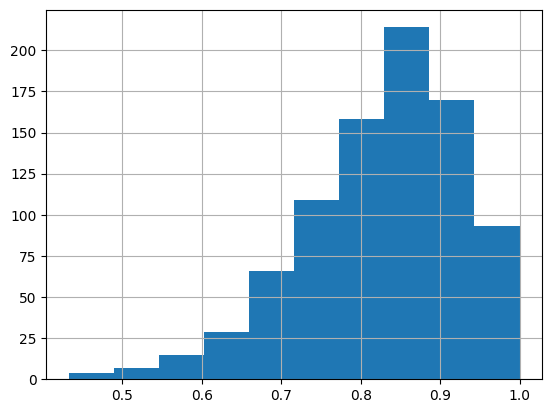

In [104]:
census_demos['Percent of People with Computers and Internet'].hist()


<Axes: >

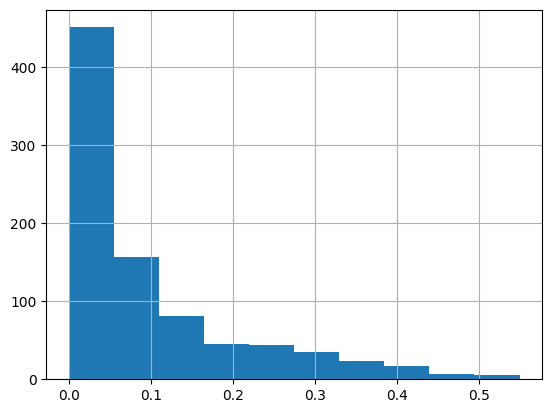

In [98]:
census_demos['Percent Households: $200,000 or more'].hist()


<Axes: >

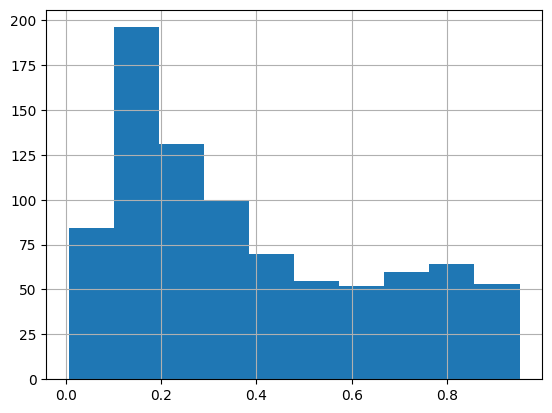

In [99]:
census_demos['Percent: 25+ Bachelor\'s Degree or More'].hist()

In [100]:
branch_vs_average['Percent: 25+ Master\'s Degree or More']

0    0.305921
0    0.160552
Name: Percent: 25+ Master's Degree or More, dtype: float64

<Axes: >

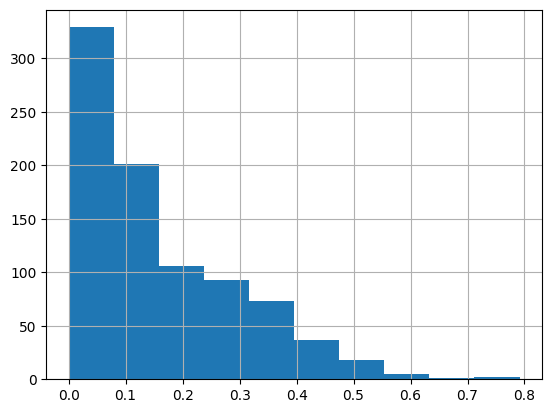

In [101]:
census_demos['Percent: 25+ Master\'s Degree or More'].hist()

In [172]:
difference_row.to_csv('../../can-summer-2023/notebooks/api/difference_row_Sulzer.csv')